<!-- https://www.kaggle.com/code/iakhtar0/63-next-word-predictor-lstm-campusx -->

In [1]:
%matplotlib inline

In [2]:
import sys
import platform
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import nltk
import sklearn

print("🔧 Environment Information")
print("=" * 40)
print(f"Python version      : {platform.python_version()}")
print(f"TensorFlow version  : {tf.__version__}")
print(f"NumPy version       : {np.__version__}")
print(f"Pandas version      : {pd.__version__}")
print(f"Matplotlib version  : {matplotlib.__version__}")
print(f"Seaborn version     : {sns.__version__}")
print(f"NLTK version        : {nltk.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print("=" * 40)

# Optional: GPU info
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
else:
    print("⚠️ No GPU detected (running on CPU).")


🔧 Environment Information
Python version      : 3.10.18
TensorFlow version  : 2.10.1
NumPy version       : 1.25.2
Pandas version      : 2.1.4
Matplotlib version  : 3.10.3
Seaborn version     : 0.13.2
NLTK version        : 3.9.2
scikit-learn version: 1.7.2
✅ GPU detected: /physical_device:GPU:0


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SriRam.A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from pathlib import Path
NOTEBOOK_DIR  = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[1]
DATASET_DIR = BASE_DIR /  "data" / 'TwitterSentimentAnalysisDataset' / "preprocessed"
DATASET_FILE_PATH = DATASET_DIR  / 'twitter_training.csv'
DATASET_FILE_PATH.exists()

True

In [5]:
df = pd.read_csv(DATASET_FILE_PATH,usecols=["sentiment","cleaned_text"],nrows=10000)
df["cleaned_text"] = df["cleaned_text"].astype(str)
print("Null values",df.isnull().sum())
print("Shape of df :",df.shape)

Null values sentiment       0
cleaned_text    0
dtype: int64
Shape of df : (10000, 2)


Max words in a sentence: 189
Average words in a sentence: 19.7168


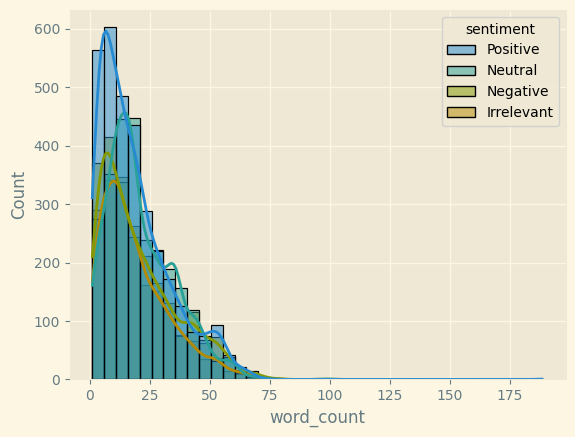

In [6]:
import matplotlib.pyplot as plt
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))
max_words = df["word_count"].max()
avg_words = df["word_count"].mean()
print("Max words in a sentence:", max_words)
print("Average words in a sentence:", avg_words)
plt.style.use('Solarize_Light2')
# sns.set_theme(style="dark")
sns.histplot(data=df,x = 'word_count',hue='sentiment',binwidth=5,kde=True)
plt.show()

In [7]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

### https://www.datacamp.com/tutorial/python-bag-of-words-model

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
# Create a CountVectorizer Object
vectorizer = CountVectorizer()
corpus  = df["cleaned_text"]
# Fit and transform the corpus
X = vectorizer.fit_transform(corpus)
# Print the generated vocabulary
print("Vocabulary:", vectorizer.get_feature_names_out())
print("Total Words i Vocabulary:", len(vectorizer.get_feature_names_out()))
# Print the Bag-of-Words matrix
print("Shape of Input",X.shape)
# X.toarray()

Vocabulary: ['ab' 'abandon' 'abandoned' ... 'zxvids' 'zy' 'zynks']
Total Words i Vocabulary: 7657
Shape of Input (9270, 7657)


In [10]:
# bow_df = pd.DataFrame(X.toarray(), 
#                       columns=vectorizer.get_feature_names_out())
# print(f"BoW Shape: {bow_df.shape}")
# bow_df.sample(5)

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])
y = to_categorical(y_encoded)

print("Shape of y:", y.shape)
print("classes :", label_encoder.classes_)
print("Label assigned :", label_encoder.transform(['Irrelevant','Negative','Neutral','Positive']))

print("\n=== Clean & Aligned Mapping ===")

# Set a fixed width for readability (20 chars for class name)
for cls in label_encoder.classes_:
    idx = label_encoder.transform([cls])[0]
    one_hot = to_categorical(idx, num_classes=len(label_encoder.classes_))
    print(f"{cls:<12} | index: {idx:<2} | one-hot: {one_hot}")


Shape of y: (9270, 4)
classes : ['Irrelevant' 'Negative' 'Neutral' 'Positive']
Label assigned : [0 1 2 3]

=== Clean & Aligned Mapping ===
Irrelevant   | index: 0  | one-hot: [1. 0. 0. 0.]
Negative     | index: 1  | one-hot: [0. 1. 0. 0.]
Neutral      | index: 2  | one-hot: [0. 0. 1. 0.]
Positive     | index: 3  | one-hot: [0. 0. 0. 1.]


In [12]:
y_encoded

array([3, 3, 3, ..., 0, 0, 0])

In [13]:
y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [14]:
from keras.models import Sequential
from keras.layers import SimpleRNN , Dense , Embedding, LSTM, GRU 
import mlflow
import mlflow.tensorflow
import warnings
warnings.filterwarnings("ignore")
print("Project base dir is :",BASE_DIR)

c:\Users\SriRam.A\miniconda3\envs\tensorflow-miniconda\lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


Project base dir is : C:\Users\SriRam.A\Documents\sr_proj\CivicSense


c:\Users\SriRam.A\miniconda3\envs\tensorflow-miniconda\lib\site-packages\pydantic\_internal\_config.py:383: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [15]:
tracking_path = f"file:///{BASE_DIR.as_posix()}/mlruns"
mlflow.set_tracking_uri(tracking_path)
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: file:///C:/Users/SriRam.A/Documents/sr_proj/CivicSense/mlruns


In [16]:
mlflow.set_experiment("1-RNN")

<Experiment: artifact_location='file:///C:/Users/SriRam.A/Documents/sr_proj/CivicSense/mlruns/908303761318665255', creation_time=1763043212205, experiment_id='908303761318665255', last_update_time=1763043212205, lifecycle_stage='active', name='1-RNN', tags={}>

In [17]:
X.shape , y.shape

((9270, 7657), (9270, 4))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X.toarray(), y, test_size=0.4, random_state=42)

In [19]:
# Define constants
timestep = X.shape[1]
input_nodes = 1
num_classes = y.shape[1]
# ---- Start MLflow Run manually ----
run =  mlflow.start_run(run_name="Twitter-BoW-NoEmbed")
# Log preprocessing details
mlflow.log_param("preprocess", "BoW")
mlflow.log_param("timesteps", timestep)
mlflow.log_param("tokenizer", "CountVectorizer")
# ---- Define and compile model ----
model = Sequential()
model.add(SimpleRNN(32, input_shape=(timestep, input_nodes),return_sequences=False))
model.add(Dense(num_classes, activation='softmax'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()
mlflow.tensorflow.autolog()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128,
)

Epoch 1/5
44/44 [==============================] - 236s 5s/step - loss: 0.6032 - accuracy: 0.2496 - val_loss: 0.5567 - val_accuracy: 0.3252
Epoch 2/5
44/44 [==============================] - 199s 5s/step - loss: 0.5570 - accuracy: 0.3209 - val_loss: 0.5568 - val_accuracy: 0.3252
Epoch 3/5
44/44 [==============================] - 226s 5s/step - loss: 0.5572 - accuracy: 0.3209 - val_loss: 0.5565 - val_accuracy: 0.3252
Epoch 4/5
44/44 [==============================] - 246s 6s/step - loss: 0.5571 - accuracy: 0.3209 - val_loss: 0.5574 - val_accuracy: 0.3252
Epoch 5/5
1/1 [==============================] - 1s 901ms/step
INFO:tensorflow:Assets written to: C:\Users\SriRam.A\AppData\Local\Temp\tmpwcv6kiq6\model\data\model\assets


In [24]:
loss, accuracy = model.evaluate(X_val,y_val)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

869/869 [==============================] - 13s 15ms/step - loss: 0.5538 - accuracy: 0.3084
Test Loss: 0.5537537932395935
Test Accuracy: 0.3084256649017334


In [21]:
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature
import numpy as np
input_schema = Schema([
    TensorSpec(np.dtype(np.float32), (-1, timestep, input_nodes), "input")
])
output_schema = Schema([
    TensorSpec(np.dtype(np.float32), (-1, num_classes), "output")
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [22]:
# ---- Log Model ----
mlflow.tensorflow.log_model(model, "model",signature=signature)
# --- Log metrics ---
val_acc = history.history["val_accuracy"][-1]
val_loss = history.history["val_loss"][-1]
mlflow.log_metric("val_accuracy", val_acc)
mlflow.log_metric("val_loss", val_loss)

INFO:tensorflow:Assets written to: C:\Users\SriRam.A\AppData\Local\Temp\tmpsqeeoi45\model\data\model\assets


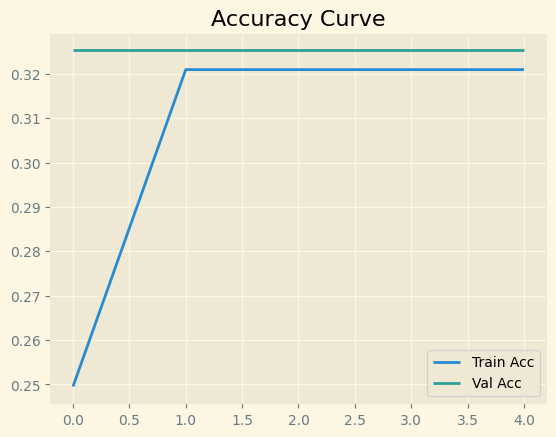

In [23]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
mlflow.log_figure(plt.gcf(), "accuracy_curve.png")
plt.show()

116/116 [==============================] - 87s 750ms/step


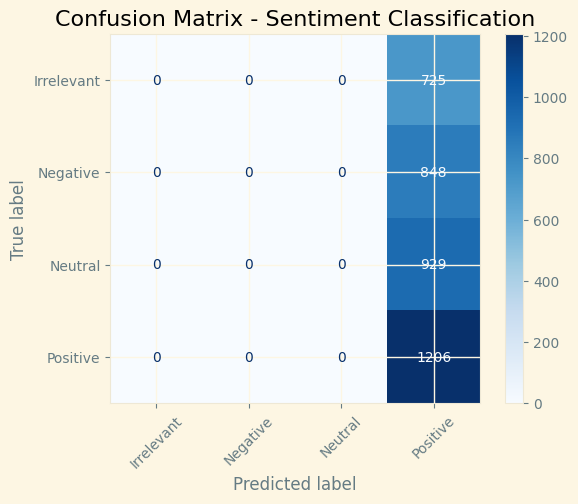


Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00       725
    Negative       0.00      0.00      0.00       848
     Neutral       0.00      0.00      0.00       929
    Positive       0.33      1.00      0.49      1206

    accuracy                           0.33      3708
   macro avg       0.08      0.25      0.12      3708
weighted avg       0.11      0.33      0.16      3708



<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1️⃣ Make predictions on the validation (test) data
y_pred = model.predict(X_val)

# 2️⃣ Convert probabilities → class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# 3️⃣ Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4️⃣ Display it visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()
mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
# 5️⃣ Optional: detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


In [25]:
mlflow.end_run()

In [26]:
! mlflow ui

^C
